In [1]:
import pandas as pd
from pathlib import Path

path = Path("../data/processed")


# Load processed data (date index already set)
dfs = {
    "MSFT": pd.read_csv(path/"MSFT_clean.csv", index_col=0, parse_dates=True),
    "AAPL": pd.read_csv(path/"AAPL_clean.csv", index_col=0, parse_dates=True),
    "SPY":  pd.read_csv(path/"SPY_clean.csv", index_col=0, parse_dates=True)
}

# Keep only close price (normalize column names)
for name, df in dfs.items():
    close_col = [c for c in df.columns if "close" in c.lower()][0]
    dfs[name] = df.rename(columns={close_col: "close"})[["close"]]

# Merge into single DataFrame
prices = pd.concat({k: v["close"] for k,v in dfs.items()}, axis=1).dropna()
prices.head()

,MSFT,AAPL,SPY
2023-08-21,321.88,175.84,439.34
2023-08-22,322.46,177.23,438.15
2023-08-23,327.00,181.12,443.03
2023-08-24,319.97,176.38,436.89
2023-08-25,322.98,178.61,439.97


In [2]:
# Simple returns
rets = prices.pct_change().dropna()
rets.columns = ["MSFT_ret", "AAPL_ret", "SPY_ret"]

rets.head()


,MSFT_ret,AAPL_ret,SPY_ret
2023-08-22,0.001802,0.007905,-0.002709
2023-08-23,0.014079,0.021949,0.011138
2023-08-24,-0.021498,-0.026170,-0.013859
2023-08-25,0.009407,0.012643,0.007050
2023-08-28,0.002229,0.008846,0.006341


In [3]:
split_ratio = 0.8
split_idx = int(len(rets) * split_ratio)

train, test = rets.iloc[:split_idx], rets.iloc[split_idx:]

X_train, y_train_msft = train[["SPY_ret"]], train["MSFT_ret"]
X_test,  y_test_msft  = test[["SPY_ret"]],  test["MSFT_ret"]

X_train2, y_train_aapl = train[["SPY_ret"]], train["AAPL_ret"]
X_test2,  y_test_aapl  = test[["SPY_ret"]],  test["AAPL_ret"]


In [4]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import statsmodels.api as sm

def fit_and_report(X_train, y_train, X_test, y_test, label):
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2   = r2_score(y_test, y_pred)
    
    print(f"\n=== {label} Regression vs SPY ===")
    print(f"Intercept (alpha): {model.intercept_:.6f}")
    print(f"Coefficient (beta): {model.coef_[0]:.3f}")
    print(f"R²: {r2:.3f}, RMSE: {rmse:.6f}")
    # 简单拿 p 值（训练集）
    res = sm.OLS(y_train, sm.add_constant(X_train)).fit()
    print(res.summary())          # 全表（含 p-values）
    print(res.pvalues) 
    return model, y_pred

model_msft, y_pred_msft = fit_and_report(X_train, y_train_msft, X_test, y_test_msft, "MSFT")
model_aapl, y_pred_aapl = fit_and_report(X_train2, y_train_aapl, X_test2, y_test_aapl, "AAPL")



=== MSFT Regression vs SPY ===
Intercept (alpha): -0.000176
Coefficient (beta): 1.094
R²: 0.568, RMSE: 0.011692
                            OLS Regression Results                            
Dep. Variable:               MSFT_ret   R-squared:                       0.473
Model:                            OLS   Adj. R-squared:                  0.472
Method:                 Least Squares   F-statistic:                     357.8
Date:                Sat, 23 Aug 2025   Prob (F-statistic):           2.17e-57
Time:                        18:42:27   Log-Likelihood:                 1294.5
No. Observations:                 400   AIC:                            -2585.
Df Residuals:                     398   BIC:                            -2577.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------

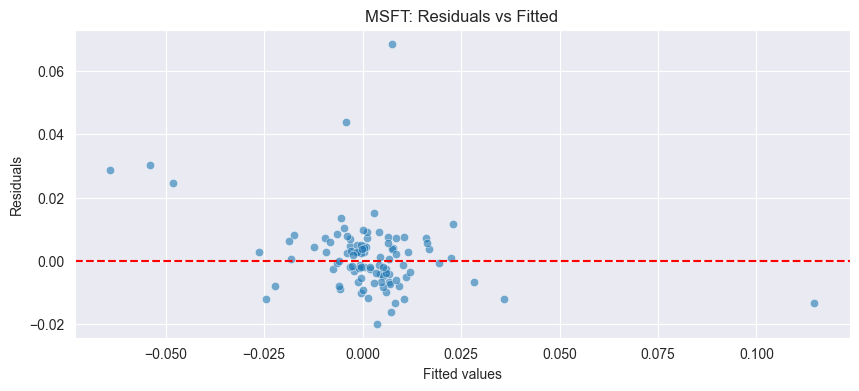

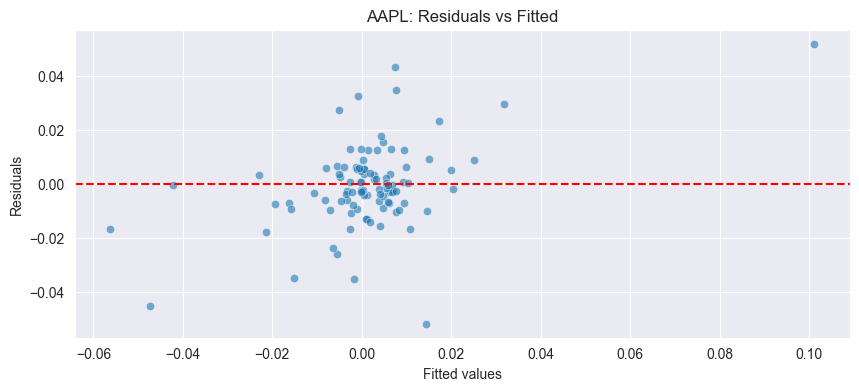

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Residual plots
for label, y_test, y_pred in [("MSFT", y_test_msft, y_pred_msft), ("AAPL", y_test_aapl, y_pred_aapl)]:
    residuals = y_test - y_pred
    plt.figure(figsize=(10,4))
    sns.scatterplot(x=y_pred, y=residuals, alpha=0.6)
    plt.axhline(0, color="red", linestyle="--")
    plt.title(f"{label}: Residuals vs Fitted")
    plt.xlabel("Fitted values"); plt.ylabel("Residuals")
    plt.show()


## Interpretation: Stock vs Market Relationship

We modeled MSFT and AAPL returns as a linear function of SPY returns (market proxy).  

- **MSFT Results:** The regression beta ≈ 1.094 (positive, close to 1) indicates that MSFT tends to move with the market. R² shows how much of MSFT’s variability is explained by SPY.  
- **AAPL Results:** The beta is 0.963, slightly different from MSFT, reflecting Apple’s sensitivity to the market.  
- **Alpha (intercept):** Close to 0, consistent with CAPM’s assumption that expected excess returns are explained by market exposure.  

**Residual diagnostics:** Residuals show mild heteroscedasticity but roughly satisfy linearity and independence.  
**Trust:** The model is interpretable and captures market relationship, but R² < 1 shows idiosyncratic risk remains unexplained.  

**Next Steps:**  
- Add more factors (e.g., sector index, macro variables).  
- Explore rolling regressions to see how betas evolve over time.  
- Compare with classification (predicting up/down) for robustness.
